In [ ]:
# Install necessary dependencies
!pip install -q scikit-learn gdown pandas numpy matplotlib seaborn dask torch torchvision torchaudio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 77.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 75.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 68.1 MB/s eta 0:00:00


In [ ]:
import os
import zipfile
import gdown
import torch
import pandas as pd
import numpy as np
import dask.dataframe as dd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from wordcloud import WordCloud
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score

/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
# Check if GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"GPU Detected: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}")
    print(f"PyTorch CUDA Support: {torch.cuda.is_available()}")
else:
    device = torch.device("cpu")
    print("No GPU Detected: Using CPU")

GPU Detected: NVIDIA A100-SXM4-40GB
CUDA Version: 12.4
PyTorch CUDA Support: True


In [ ]:
!gdown 1-I9EMAvc-GARgIMLQI3CxWt4AJfTAQQG

Downloading...
From (original): https://drive.google.com/uc?id=1-I9EMAvc-GARgIMLQI3CxWt4AJfTAQQG
From (redirected): https://drive.google.com/uc?id=1-I9EMAvc-GARgIMLQI3CxWt4AJfTAQQG&confirm=t&uuid=c83a3792-be09-40c6-a246-cea8518a1abd
To: /content/embedding.zip
100% 6.42G/6.42G [01:12<00:00, 88.8MB/s]


In [ ]:
# Define the script and ZIP file
zip_path = "/content/embedding.zip"
extract_path = "/content/extracted_embeddings"

# Extract the embeddings
if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extract_path)

# List the extracted files
embedding_files = [f for f in os.listdir(extract_path) if f.endswith(".csv")]
print(f"Extracted files: {embedding_files}")

Extracted files: ['arxiv_preprocessed_part4_embedded.csv', 'arxiv_preprocessed_part1_embedded.csv', 'arxiv_preprocessed_part11_embedded.csv', 'arxiv_preprocessed_part2_embedded.csv', 'arxiv_preprocessed_part13_embedded.csv', 'arxiv_preprocessed_part10_embedded.csv', 'arxiv_preprocessed_part3_embedded.csv', 'arxiv_preprocessed_part5_embedded.csv', 'arxiv_preprocessed_part6_embedded.csv', 'arxiv_preprocessed_part9_embedded.csv', 'arxiv_preprocessed_part0_embedded.csv', 'arxiv_preprocessed_part7_embedded.csv', 'arxiv_preprocessed_part8_embedded.csv', 'arxiv_preprocessed_part12_embedded.csv']


In [ ]:
# Initialize list to store valid DataFrames
dfs = []

print("\nLoading files with tqdm for better progress tracking...")
for file in tqdm(embedding_files, desc="Processing Files"):
    file_path = os.path.join(extract_path, file)
    try:
        # Load CSV with automatic dtype detection
        df = pd.read_csv(file_path, encoding="utf-8", dtype={"year": int, "month": int}, low_memory=False)

        # Ensure embeddings are converted from string to a list of floats
        df["abstract_embedding"] = df["abstract_embedding"].apply(
            lambda x: list(map(float, x.strip("[]").split(","))) if isinstance(x, str) else x
        )

        dfs.append(df)

    except Exception as e:
        print(f"⚠️ Error reading {file}: {e}")

# Concatenate only valid DataFrames
if dfs:
    df = pd.concat(dfs, ignore_index=True)  # Keep Pandas for consistency
    print("✅ Data loaded successfully")
else:
    raise ValueError("❌ No valid CSV files could be loaded.")

# Convert 'abstract_embedding' from list to a PyTorch tensor for GPU acceleration
X = torch.tensor(np.vstack(df["abstract_embedding"].values), dtype=torch.float32, device=device)


Loading files with tqdm for better progress tracking...


Processing Files: 100%|██████████| 14/14 [06:05<00:00, 26.09s/it]


✅ Data loaded successfully


In [ ]:
# Define number of clusters
num_clusters = 5

# Dictionary to store clustering results
cluster_results = {}

# Perform clustering for each year and month (parallelized)
for (year, month), sub_df in df.groupby(["year", "month"]):
    print(f"\nProcessing Year: {year}, Month: {month} (Samples: {len(sub_df)})")

    if len(sub_df) < num_clusters:  # Skip small samples
        print(f"Skipping {year}-{month} due to insufficient data.")
        continue

    # Convert embeddings for this time period
    X_sub = torch.tensor(np.vstack(sub_df["abstract_embedding"].values), dtype=torch.float32, device=device)

    # Apply MiniBatch K-Means (optimized for large datasets)
    kmeans = MiniBatchKMeans(n_clusters=num_clusters, random_state=42, batch_size=256, n_init=10)
    sub_df["cluster"] = kmeans.fit_predict(X_sub.cpu().numpy())  # Move to CPU before applying K-Means

    # Evaluate clustering performance
    inertia = kmeans.inertia_
    silhouette_avg = silhouette_score(X_sub.cpu().numpy(), sub_df["cluster"])

    print(f"K-Means Inertia: {inertia}")
    print(f"Silhouette Score: {silhouette_avg}")

    # Store clustering results
    cluster_results[(year, month)] = sub_df

# Combine clustered data
clustered_df = pd.concat(cluster_results.values())


Processing Year: 2007, Month: 5 (Samples: 130276)
K-Means Inertia: 681004.375
Silhouette Score: 0.028450656682252884

Processing Year: 2007, Month: 6 (Samples: 3024)
K-Means Inertia: 15628.6357421875
Silhouette Score: 0.04379798844456673

Processing Year: 2007, Month: 7 (Samples: 2653)
K-Means Inertia: 13012.84375
Silhouette Score: 0.020779434591531754

Processing Year: 2007, Month: 8 (Samples: 1770)
K-Means Inertia: 9443.9443359375
Silhouette Score: 0.014003570191562176

Processing Year: 2007, Month: 9 (Samples: 1862)
K-Means Inertia: 9848.029296875
Silhouette Score: 0.022234579548239708

Processing Year: 2007, Month: 10 (Samples: 2254)
K-Means Inertia: 11963.8935546875
Silhouette Score: 0.01932140253484249

Processing Year: 2007, Month: 11 (Samples: 2073)
K-Means Inertia: 11265.9990234375
Silhouette Score: 0.0296319592744112

Processing Year: 2007, Month: 12 (Samples: 1857)
K-Means Inertia: 9596.5107421875
Silhouette Score: 0.007490941789001226

Processing Year: 2008, Month: 1 (Samp

In [ ]:
# Apply GPU-accelerated PCA using PyTorch
def pca_torch(X, n_components=2):
    # Compute mean and subtract it
    X_mean = X.mean(dim=0)
    X_centered = X - X_mean

    # Compute covariance matrix
    cov_matrix = torch.mm(X_centered.T, X_centered) / (X.shape[0] - 1)

    # Compute eigenvalues and eigenvectors
    eigvals, eigvecs = torch.linalg.eigh(cov_matrix)

    # Sort eigenvectors by descending eigenvalues
    sorted_indices = torch.argsort(eigvals, descending=True)
    top_eigvecs = eigvecs[:, sorted_indices[:n_components]]

    # Project data onto principal components
    X_pca = torch.mm(X_centered, top_eigvecs)

    return X_pca

# Apply PCA on GPU if available
X_pca = pca_torch(X, n_components=2).cpu().numpy()

In [ ]:
# Add PCA results to DataFrame
clustered_df["pca_1"] = X_pca[:, 0]
clustered_df["pca_2"] = X_pca[:, 1]

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


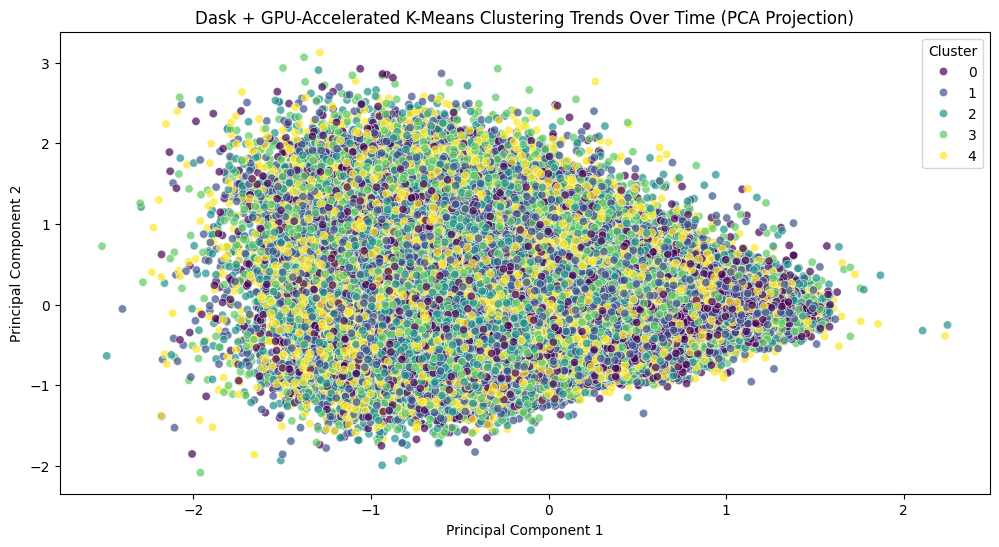

In [ ]:
# Plot clustering trends over time
plt.figure(figsize=(12, 6))
sns.scatterplot(data=clustered_df, x="pca_1", y="pca_2", hue="cluster", palette="viridis", alpha=0.7)
plt.title("Dask + GPU-Accelerated K-Means Clustering Trends Over Time (PCA Projection)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster")
plt.show()

In [ ]:
print(clustered_df.columns)

Index(['id', 'abstract', 'update_date', 'year', 'month', 'authors',
       'abstract_embedding', 'cluster', 'pca_1', 'pca_2'],
      dtype='object')



Generating Word Clouds for Each Cluster...


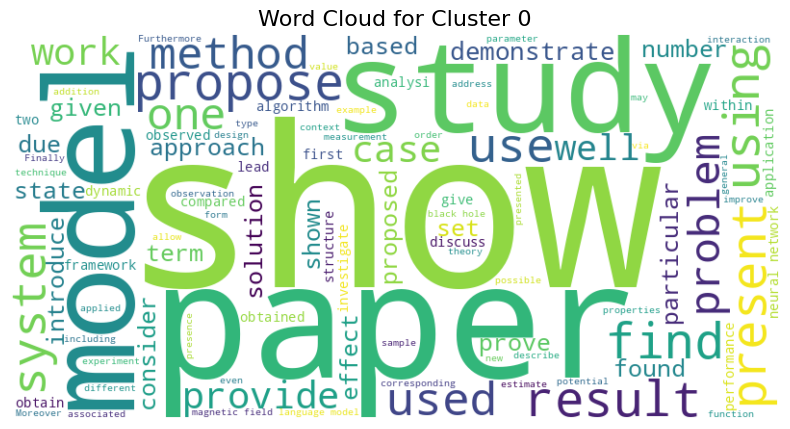

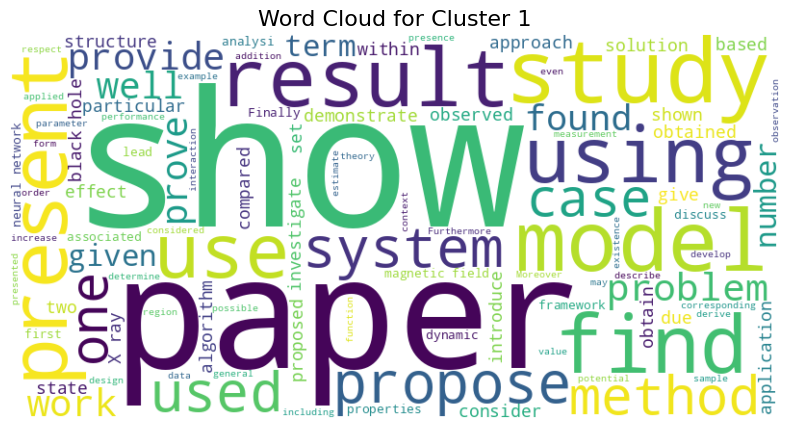

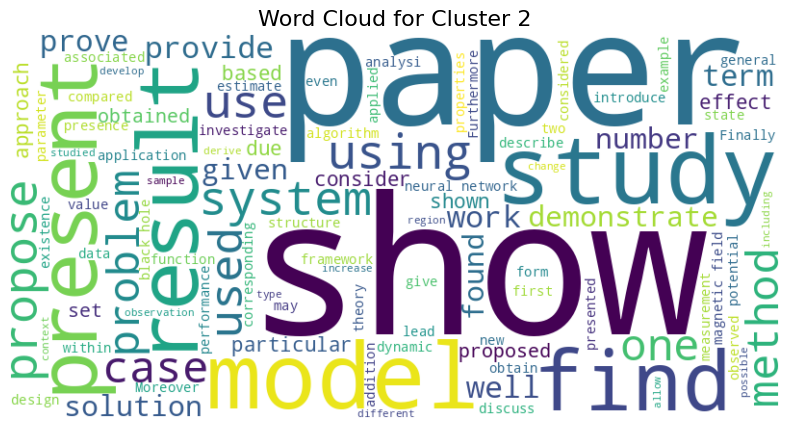

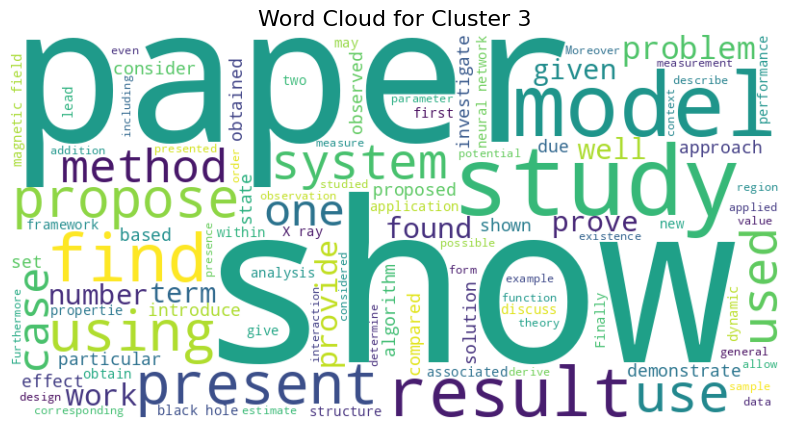

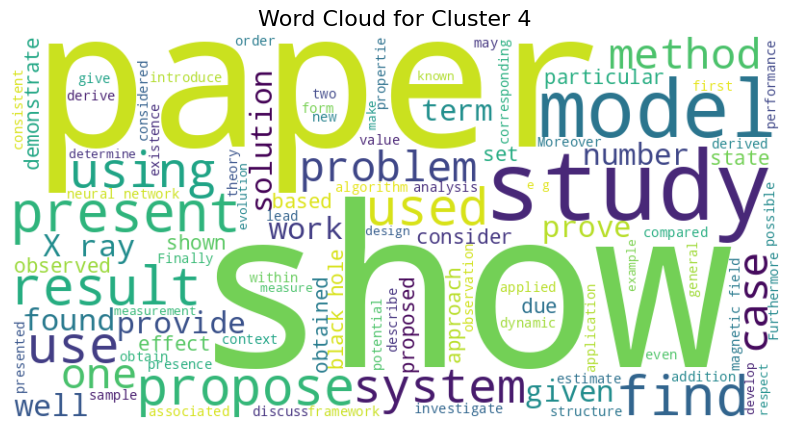

In [ ]:
def plot_word_clouds(df, text_column="abstract", cluster_column="cluster"):
    """
    Generate word clouds for each cluster based on the provided text column.

    Parameters:
    - df (pd.DataFrame): DataFrame containing clustered data.
    - text_column (str): Column to use for generating word clouds.
    - cluster_column (str): Column containing cluster labels.
    """
    clusters = sorted(df[cluster_column].unique())

    for cluster_num in clusters:
        # Combine all text from the chosen column for this cluster
        cluster_text = " ".join(df[df[cluster_column] == cluster_num][text_column].astype(str).values)

        # Generate Word Cloud
        wordcloud = WordCloud(
            width=800,
            height=400,
            background_color="white",
            colormap="viridis",
            max_words=100,
            contour_width=2,
            contour_color='steelblue'
        ).generate(cluster_text)

        # Plot the Word Cloud
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.title(f"Word Cloud for Cluster {cluster_num}", fontsize=16)
        plt.show()

# Generate Word Clouds for Each Cluster
print("\nGenerating Word Clouds for Each Cluster...")
plot_word_clouds(clustered_df, text_column="abstract", cluster_column="cluster")

In [ ]:
# Analyze keyword trends over time
print("\nKeyword Trends Over Time:")
for (year, month), sub_df in cluster_results.items():
    print(f"\nYear: {year}, Month: {month}")
    for cluster in range(num_clusters):
        cluster_data = sub_df[sub_df["cluster"] == cluster]
        print(f"Cluster {cluster}: {len(cluster_data)} samples")


Keyword Trends Over Time:

Year: 2007, Month: 5
Cluster 0: 55 samples
Cluster 1: 23931 samples
Cluster 2: 12672 samples
Cluster 3: 21869 samples
Cluster 4: 71749 samples

Year: 2007, Month: 6
Cluster 0: 162 samples
Cluster 1: 1134 samples
Cluster 2: 309 samples
Cluster 3: 1113 samples
Cluster 4: 306 samples

Year: 2007, Month: 7
Cluster 0: 333 samples
Cluster 1: 332 samples
Cluster 2: 933 samples
Cluster 3: 490 samples
Cluster 4: 565 samples

Year: 2007, Month: 8
Cluster 0: 2 samples
Cluster 1: 480 samples
Cluster 2: 1155 samples
Cluster 3: 131 samples
Cluster 4: 2 samples

Year: 2007, Month: 9
Cluster 0: 257 samples
Cluster 1: 379 samples
Cluster 2: 748 samples
Cluster 3: 393 samples
Cluster 4: 85 samples

Year: 2007, Month: 10
Cluster 0: 806 samples
Cluster 1: 500 samples
Cluster 2: 494 samples
Cluster 3: 25 samples
Cluster 4: 429 samples

Year: 2007, Month: 11
Cluster 0: 447 samples
Cluster 1: 830 samples
Cluster 2: 2 samples
Cluster 3: 2 samples
Cluster 4: 792 samples

Year: 2007,

# Removing Frequent Non-stop Words

In [ ]:
from collections import Counter

# Find Global Word Frequency Across All Clusters
global_word_counts = Counter()

for (year, month), sub_df in cluster_results.items():
    for cluster_num in range(num_clusters):
        combined_text = " ".join(sub_df[sub_df["cluster"] == cluster_num]["abstract"].astype(str).values)
        global_word_counts.update(combined_text.split())

# Define `max_df` threshold (e.g., words appearing in over 70% of clusters are removed)
total_clusters = len(cluster_results) * num_clusters
max_df = 0.7 * total_clusters  # Adjust as needed

# Create a set of high-frequency "domain-specific stop words"
high_frequency_words = {word for word, count in global_word_counts.items() if count > max_df}

print(f"Filtering out {len(high_frequency_words)} common words: {list(high_frequency_words)}")

Filtering out 21293 common words: ['resolving', 'invariants', 'rescaled', 'another,', 'Band', 'targets,', 'tensor,', '$\\mathbf', 'parametrize', 'academia', 'Catalog', 'implemented.', 'employ', 'transitions', 'multiscale', 'PACS', 'incompressibility', 'hypersurface', 'long', 'driver']...


In [ ]:
# Find Top Words per Cluster (After Filtering)
top_words_by_cluster = {}

for (year, month), sub_df in cluster_results.items():
    cluster_top_words = {}
    for cluster_num in range(num_clusters):
        cluster_data = sub_df[sub_df["cluster"] == cluster_num]

        # Combine abstracts
        combined_text = " ".join(cluster_data["abstract"].astype(str).values)

        # Filter high-frequency words
        filtered_words = [word for word in combined_text.split() if word not in high_frequency_words]

        # Count most common filtered words
        word_counts = Counter(filtered_words)
        top_words = word_counts.most_common(15)  # Top 15 words per cluster

        cluster_top_words[cluster_num] = top_words

    # Store results for this year and month
    if year not in top_words_by_cluster:
        top_words_by_cluster[year] = {}
    top_words_by_cluster[year][month] = cluster_top_words

In [ ]:
# Display Top Words for Selected Year/Month
def display_top_words(year, month):
    """
    Display the top repeated words for each cluster in a given year and month,
    after filtering out high-frequency common words.
    """
    if year not in top_words_by_cluster or month not in top_words_by_cluster[year]:
        print(f"No data available for {year}-{month}")
        return

    print(f"\nDistinct Top Words for {year}-{month}:")
    for cluster_num, top_words in top_words_by_cluster[year][month].items():
        words = ", ".join([f"{word} ({count})" for word, count in top_words])
        print(f"Cluster {cluster_num}: {words}")

In [ ]:
# Example: View top words for 2007, May
display_top_words(2007, 5)


Distinct Top Words for 2007-5:
Cluster 0: AdS/SYM (2), Selberg's (2), SO(n) (1), 8) (1), generalizations, (1), co-dimension (1), (SYM) (1), gauge-transformation (1), (weak (1), (minimal (1), surface) (1), (color)superconductivity (1), groves, (1), SU(2,2/N) (1), "harmonic (1)
Cluster 1: coalgebra (95), etale (95), Littlewood-Richardson (87), quasi-Hopf (85), Groebner (84), bimodule (83), withdrawn. (78), (mod (78), Rees (76), Kauffman (75), Connes (75), $\frak (71), Cuntz (70), Garside (69), selfadjoint (66)
Cluster 2: 3-folds (105), Teichmuller (92), 3-manifolds. (91), submanifolds. (76), Donaldson (74), 3-space (63), hyperkaehler (56), biholomorphic (56), 1-forms (52), real-analytic (52), threefolds. (50), 3-fold (50), Weil-Petersson (49), Vassiliev (48), Teichmueller (48)
Cluster 3: PEP-II (135), HERA. (116), LSND (109), hadron-hadron (90), ep (87), MSW (86), SLAC (82), LEP2 (78), pi^0 (75), $\alpha_s$ (72), (MSSM) (70), nonleptonic (69), GZK (68), Upsilon(4S) (65), mSUGRA (63)
Clu

In [ ]:
# Generate Word Clouds for Each Cluster
print("\nGenerating Word Clouds for Each Cluster...")
plot_word_clouds(clustered_df, text_column="abstract", cluster_column="cluster")